### Console for pip/conda installs on the fly


In [200]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} pandas

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\gunne\anaconda3\envs\cs791

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.11.8          |   py38haa95532_0         148 KB
    openssl-1.1.1h             |       he774522_0         4.8 MB
    pandas-1.1.3               |   py38ha925a31_0         7.5 MB
    pytz-2020.1                |             py_0         184 KB
    ------------------------------------------------------------
                                           Total:        12.6 MB

The following NEW packages will be INSTALLED:

  pandas             pkgs/main/win-64::pandas-1.1.3-py38ha925a31_0
  pytz               pkgs/main/noarch::pytz-2020.1-py_0

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2020.6.2~ --> pkgs/main::ca-certificates-



==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda




In [8]:
import numpy as np
from time import time, sleep

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from torch.optim.lr_scheduler import StepLR
from random import shuffle
import random


from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import pandas as pd


import math 

from tqdm.notebook import tqdm

Global Variables & GPU/CPU handling

In [9]:
#Sets random seed to the same number so you get same results every time (for benchmarking purposes)
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

#arbitrary variable, set as high as your vram allows
train_batch_size = 600 #60% data
validation_batch_size = int(train_batch_size/3) #20% data

#total runs through the entire dataset
epochs = 556

#step size in 
learning_rate = 1.75e-3


#flattened latent layer size
#needs to have an integer sqrt
bottleneck_size = 64

#leftover varaible for a encoder/decoder variable I'm too lazy to hardcode again
net_size = 324


#help see if you can use GPU or CPU
use_cuda = torch.cuda.is_available()
dtype = 'float32' if use_cuda else 'float64'
torchtype = {'float32': torch.float32, 'float64': torch.float64}

## Kmeans accuracy function

Returns 0<x<1 depending on accuracy of kmeans label classification

Requires: 
    
    Shape of centroids: (2, X)

    Shape of data: (6000, 2)

    Shape of latent image (ie: data[n][0]): (X,)

    Shape of latent label (ie: data[n][1]): (2,)


In [10]:
"""
N = total dimensions of representation (for 8x8 representation n = 64)
clusters = 2 x N array representing the two cluster centers of k means
data = NumImages x 2 array containing flattened representations and labels 
        (the "2" contains an N dimension flattened representation and a size 2 one hot array for labels)
        
Data is as follows:
data[x] = set of one flattened representation with labels
data[x][0] = N size flattened representation
data[x][1] = one hot array with labels
"""
def accuracy(clusters, data):
    cluster1 = 0
    cluster2 = 0
    for i in range(len(data)):
        dist1 = 0
        dist2 = 0
        for j in range(len(data[i][0])):
            dist1 = dist1 + ((data[i][0][j] + clusters[0][j]))**2
            dist2 = dist2 + ((data[i][0][j] + clusters[1][j])) ** 2
        dist1 = math.sqrt(dist1)
        dist2 = math.sqrt(dist2)
        if dist1 > dist2:
            if data[i][1][0] == 0:
                cluster1 = cluster1 - 1
            else:
                cluster1 = cluster1 + 1
        else:
            if data[i][1][0] == 0:
                cluster2 = cluster2 - 1
            else:
                cluster2 = cluster2 + 1
    # 1 is for label = [1, 0]
    # -1 is for label = [0,1]
    if cluster1 >= cluster2:
        cluster1 = 1
        cluster2 = -1
    else:
        cluster1 = -1
        cluster2 = 1
    acc = 0
    for i in range(len(data)):
        dist1 = 0
        dist2 = 0
        for j in range(len(data[i][0])):
            dist1 = dist1 + ((data[i][0][j] + clusters[0][j])) ** 2
            dist2 = dist2 + ((data[i][0][j] + clusters[1][j])) ** 2
        dist1 = math.sqrt(dist1)
        dist2 = math.sqrt(dist2)
        if dist1 > dist2: # If belongs to cluster1
            if data[i][1][0] == 0: # If non-rigid (label = [0, 1]
                if cluster1 < 0:
                    acc = acc + 1
            else: # if rigid (label = [1,0])
                if cluster1 > 0:
                    acc = acc + 1
        else: # If belongs to cluster2
            if data[i][1][0] == 0: # If non-rigid (label = [0, 1]
                if cluster2 < 0:
                    acc = acc + 1
            else: # if rigid (label = [1,0])
                if cluster2 > 0:
                    acc = acc + 1
    acc = acc/len(data)
    return acc

## Autoencoder Class
10 layers total
- 784 (original flattened 28x28)  -> 324
- 324 -> 256
- 256 -> 121
- 121 -> 81
- 81 -> 64
- 64 -> 81
- 81 -> 121
- 121 -> 256
- 256 -> 324
- 324 -> 784

In [11]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=net_size
        )
        self.encoder_output_layer = nn.Linear(
            in_features=net_size, out_features=256
        )
        self.extra_one_layer = nn.Linear(
            in_features=256, out_features=121
        )

        self.extra_bufferone_layer = nn.Linear(
            in_features=121, out_features=81
        )
        
        #Latent representation layer
        self.extra_two_layer = nn.Linear( 
            in_features=81, out_features=bottleneck_size
        )
        
        #classification layer
        #ALEXIS
        # size in should be 64
        # size out should be 2 (one for each class)
        self.perceptron_layer = nn.Linear(
            in_features=bottleneck_size, out_features=2
        )
        
        self.extra_three_layer = nn.Linear(
            in_features=bottleneck_size, out_features=81
        )

        self.extra_buffertwo_layer = nn.Linear(
            in_features=81, out_features=121
        )

        self.extra_four_layer = nn.Linear(
            in_features=121, out_features=256
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=256, out_features=net_size
        )
        
        #reconstruction layer
        self.decoder_output_layer = nn.Linear(
            in_features=net_size, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)

        activation = self.encoder_output_layer(activation)
        activation = torch.relu(activation)


        activation = self.extra_one_layer(activation)
        activation = torch.relu(activation)

        activation = self.extra_bufferone_layer(activation)
        activation = torch.relu(activation)

        code1 = self.extra_two_layer(activation)
        activation = torch.relu(code1)
        
        
        # ALEXIS 
        # This is in forward pass
        # runs the 8x8 latent representation on this classifier branch
        # o2 should be a one-hot vector with class labels
        o2 = self.perceptron_layer(code1)
        o2 = torch.sigmoid(o2)

        activation = self.extra_three_layer(activation)
        activation = torch.relu(activation)

        activation = self.extra_buffertwo_layer(activation)
        activation = torch.relu(activation)

        activation = self.extra_four_layer(activation)
        activation = torch.relu(activation)

        activation = self.decoder_hidden_layer(activation)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)

        return reconstructed, code1, o2

def bench_k_means(estimator, name, data):
    #t0 = time()
    estimator.fit(data)
    """
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))
                                      """

## Make DataLoaders for training/validation

In [14]:
##GETS DATA IN A DATALOADER (PYTORCH'S PREFERRED BATCH METHOD)

#Read data from .npy file
start = time()
data = np.load("training_data.npy",allow_pickle=True)
shuffle(data)#shuffles data (very fast)
end = time()
# data[0] = image and labels
# data[0][0] = image
# data[0][1] = one hot array with labels
# data[0][0][0] = one line of image

#only get the first 30k data samples 
#Lower this to avoid overloading ram when testing
data = data[1:30000]


#setup the transformation that data will undergo when in dataloader
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

#separate images/labels and extract 60% of them from original data
training_dataset = []
training_labels = []
train_len = 0

for i in range(int(len(data)-(2*len(data)/5))): #60% of data is training
    training_dataset.append(data[i][0])
    training_labels.append(data[i][1])
    train_len += 1

#separate images/labels and extract 60% of them from original data
validation_dataset = []
validation_labels = []
val_len = 0

for i in range(int(len(data)-(2*len(data)/5)),int(len(data)-(2*len(data)/5))+int(len(data)/5)): #20% of data is validation
    validation_dataset.append(data[i][0])
    validation_labels.append(data[i][1])
    val_len += 1


#transform image/label pairs to Tensors (needed to use dataloader)
tensor_x = torch.Tensor(np.array(training_dataset)) # transform to torch tensor
tensor_y = torch.Tensor(np.array(training_labels).astype('float64'))


#combine tensors to a TensorDataset (keyword function from pytorch)
my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset

#transform image/label pairs to Tensors (needed to use dataloader)
tensor_x = torch.Tensor(np.array(validation_dataset)) # transform to torch tensor
tensor_y = torch.Tensor(np.array(validation_labels).astype('float64'))

my_validation_dataset = TensorDataset(tensor_x,tensor_y)

#setup the dataloader
train_loader = torch.utils.data.DataLoader(
    my_dataset, batch_size=train_batch_size, shuffle=False
)

validation_loader = torch.utils.data.DataLoader(
    my_validation_dataset, batch_size=validation_batch_size, shuffle=False
)

data_loaders = {"train": train_loader, "val": validation_loader}
data_lengths = {"train": train_len, "val": val_len}

print(data_lengths['train'])
print(data_lengths['val'])


17999
5999


## Run snippet below to train network

data = data[1:x] 

change x to get a larger set


In [15]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# loss for image-reconstruction with mean-squared error loss
criterion = nn.MSELoss()
# loss for classifier
criterion_classifier = nn.MSELoss()


#history of loss (for graphing purposes)
train_losses = []
train_ae_losses = []
train_cl_losses = []

val_losses = []
val_ae_losses = []
val_cl_losses = []

#history of latent representations
latent_representations = []

#index counting variables
epoch_index = 0
label_counter =0


#progress bar for training
pbar = tqdm(range(epochs))
for epoch in pbar:
    train_loss = 0
    train_total_loss = 0
    train_ae_loss = 0
    train_cl_loss = 0
    
    val_loss = 0
    val_ae_loss = 0
    val_cl_loss = 0
    
    train_len = 0
    val_len = 0
    
    for phase in ['train', 'val']:
#         if phase == 'train':
#             model.train(True)  # Set model to training mode
#         else:
#             model.train(False) # Set model to evaluate mode
            
        # Iterate over data.
        for i, data in enumerate(data_loaders[phase], 0):

        #for i, data in enumerate(train_loader, 0): #Used to have ,_ in front of batch_features

            # get the inputs; data is a list of [inputs, labels]
            batch_features, labels = data

            #send data to  the GPU/CPU
            batch_features = batch_features.view(-1,784).to(device)
            labels = labels.to(device)

            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()

            # compute reconstructions
            #o1 is reconstruction
            #o2 is classifier decision
            o1, latent, o2 = model(batch_features)

            # compute training reconstruction loss (need to pass original image to compare with)
            reconstruction_loss = criterion(o1, batch_features).to(device)
            
            # compute  classifier loss (needs to pass labels to compare with)
            classifier_loss = criterion_classifier(o2, labels).to(device)

            # compute a total loss
            train_loss = reconstruction_loss + (3000*classifier_loss) 

            
            if phase == 'train':
                # compute accumulated gradients
                train_loss.backward()
                # perform parameter update based on current gradients
                optimizer.step()
                # add the mini-batch training loss to epoch loss
                train_total_loss += train_loss.item()
                train_ae_loss += reconstruction_loss.item()
                train_cl_loss += 3000*classifier_loss.item()
                train_len = len(o1)
            else:
                # add the mini-batch training loss to epoch loss
                val_loss += train_loss.item()
                val_ae_loss += reconstruction_loss.item()
                val_cl_loss += 3000*classifier_loss.item()
                val_len = len(o1)

    # itterate epoch index
    epoch_index += 1
        
    # compute the epoch training loss
    train_total_loss = (train_total_loss / len(data_loaders['train']))
    train_ae_loss = (train_ae_loss / len(data_loaders['train']))
    train_cl_loss = (train_cl_loss / len(data_loaders['train']))

    
    val_loss = (val_loss / len(data_loaders['val']))
    val_ae_loss = (val_ae_loss / len(data_loaders['val']))
    val_cl_loss = (val_cl_loss / len(data_loaders['val']))

    
    #append epoch loss to history of loss
    train_losses.append(train_total_loss)
    train_ae_losses.append(train_ae_loss)
    train_cl_losses.append(train_cl_loss)

    val_losses.append(val_loss)
    val_ae_losses.append(val_ae_loss)
    val_cl_losses.append(val_cl_loss)
    
    # display the epoch training loss
    pbar.set_postfix({'total loss': "{:.8f}".format(train_total_loss)})
    #print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))



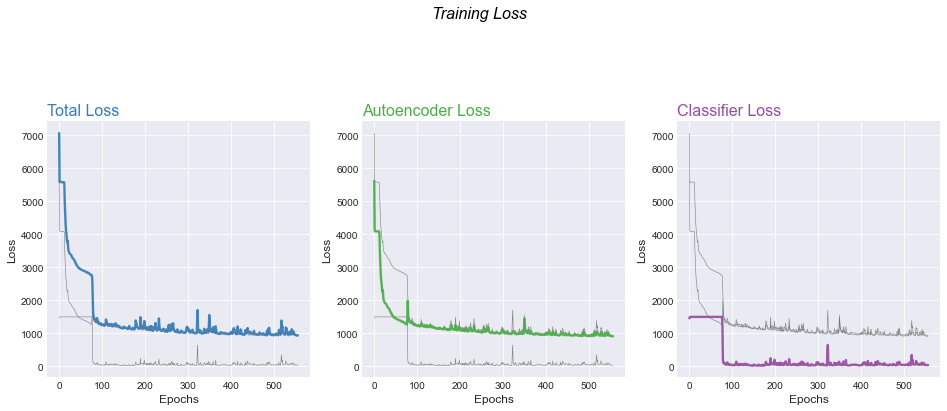

In [16]:


# Make a data frame
df=pd.DataFrame({'x': range(epochs), 
                 'Total Loss': train_losses, 
                 'Autoencoder Loss': train_ae_losses, 
                 'Classifier Loss': train_cl_losses})

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df.drop('x', axis=1):
    num+=1
 
    # Find the right spot on the plot
    ax = plt.subplot(3,3, num)
    ax.set_xlabel('Epochs',fontsize=12)
    ax.set_ylabel('Loss',fontsize=12)
    # plot every groups, but discreet
    for v in df.drop('x', axis=1):
        plt.plot(df['x'], df[v], marker='', color='dimgrey', linewidth=0.6, alpha=0.8)
 
    # Plot the lineplot
    plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=2.4, alpha=0.9, label=column)
 
    # Same limits for everybody!
#     plt.xlim(0,10)
#     plt.ylim(-2,22)
 
#     # Not ticks everywhere
#     if num in range(7) :
#         plt.tick_params(labelbottom='off')
#     if num not in [1,4,7] :
#         plt.tick_params(labelleft='off')
 
    # Add title
    plt.title(column, loc='left', fontsize=16, fontweight=0, color=palette(num) )
 
# general title
plt.suptitle("Training Loss", fontsize=16, fontweight=0, color='black', style='italic')

#plt.figure(figsize=(120,120))
plt.gcf().set_size_inches(16, 16)

#plt.text(0.06, 0.5, 'Note', ha='center', va='center', rotation='vertical')
plt.show()



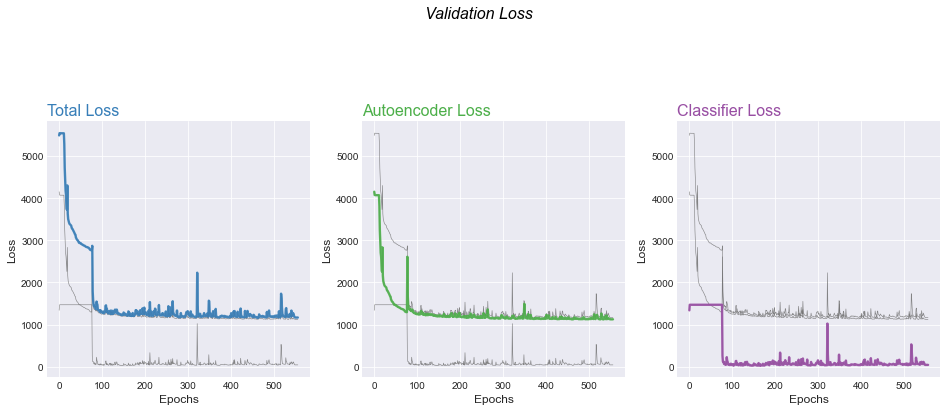

In [17]:
# Make a data frame
df=pd.DataFrame({'x': range(epochs), 
                 'Total Loss': val_losses, 
                 'Autoencoder Loss': val_ae_losses, 
                 'Classifier Loss': val_cl_losses})

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df.drop('x', axis=1):
    num+=1
 
    # Find the right spot on the plot
    ax = plt.subplot(3,3, num)
    ax.set_xlabel('Epochs',fontsize=12)
    ax.set_ylabel('Loss',fontsize=12)
    # plot every groups, but discreet
    for v in df.drop('x', axis=1):
        plt.plot(df['x'], df[v], marker='', color='dimgrey', linewidth=0.6, alpha=0.8)
 
    # Plot the lineplot
    plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=2.4, alpha=0.9, label=column)
 
    # Same limits for everybody!
#     plt.xlim(0,10)
#     plt.ylim(-2,22)
 
#     # Not ticks everywhere
#     if num in range(7) :
#         plt.tick_params(labelbottom='off')
#     if num not in [1,4,7] :
#         plt.tick_params(labelleft='off')
 
    # Add title
    plt.title(column, loc='left', fontsize=16, fontweight=0, color=palette(num) )
 
# general title
plt.suptitle("Validation Loss", fontsize=16, fontweight=0, color='black', style='italic')

#plt.figure(figsize=(120,120))
plt.gcf().set_size_inches(16, 16)

#plt.text(0.06, 0.5, 'Note', ha='center', va='center', rotation='vertical')
plt.show()

## Test the model

In [18]:
test_dataset = []
test_labels = []
#print(int((len(data)/5)*4))
#print(len(data))
for i in range(int((len(data)/5)*4),len(data)): #last 20% of data is test
    #for j in range(len(data[i][0])):
    test_dataset.append(data[i][0])
    test_labels.append(data[i][1])

#transform image/label pairs to Tensors (needed to use dataloader)
tensor_x = torch.Tensor(np.array(training_dataset)) # transform to torch tensor
tensor_y = torch.Tensor(np.array(training_labels))

#combine tensors to a TensorDataset (keyword function from pytorch)
my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset

#setup the dataloader
test_loader = torch.utils.data.DataLoader(
    my_dataset, batch_size=train_batch_size, shuffle=False
)
    
test_example = None
test_examples = []
reconstruction_examples = []
actual_labels = []
test_labels = []
k_representations = []

with torch.no_grad():
    for i, data in enumerate(train_loader, 0): #Used to have ,_ in front of batch_features
        
        # get the inputs; data is a list of [inputs, labels]
        batch_features, labels = data
        
        test_example = batch_features.view(-1, 784).to(device)
        reconstruction, representation,o2 = model(test_example)
#         print(np.shape(np.array(reconstruction.cpu().view(-1,28,28))))
#         print(np.shape(np.array(representation.cpu().view(-1,8,8))))
#         print(np.shape(np.array(o2.cpu())))
        #reformat data to be easily displayed
        batch_features = np.array(batch_features.cpu())
        reconstruction = np.array(reconstruction.cpu().view(-1,28,28))
        representation = np.array(representation.cpu().view(-1,8,8))
        o2 = np.array(o2.cpu())
        
        #append data one at a time to their own numpy tuple
        for i in range(len(o2)):
            test_examples.append(batch_features[i])
            reconstruction_examples.append(reconstruction[i])
            k_representations.append(representation[i])
            test_labels.append(o2[i])
            actual_labels.append(labels[i])
    
#         test_examples.append(np.array(reconstruction.cpu().view(-1,28,28)))
#         reconstruction_examples.append(np.array(representation.cpu().view(-1,8,8)))
#         test_labels.append(np.array(o2.cpu()))
# #         actual_labels.append(labels[0])
# #         test_labels.append(o2[0])
# #         reconstruction_examples.append(reconstruction.cpu().numpy().reshape(28,28))
#         k_representations.append(representation.cpu().numpy().reshape(-1,int(math.sqrt(bottleneck_size)),int(math.sqrt(bottleneck_size))))



## Run below to get samples of your test

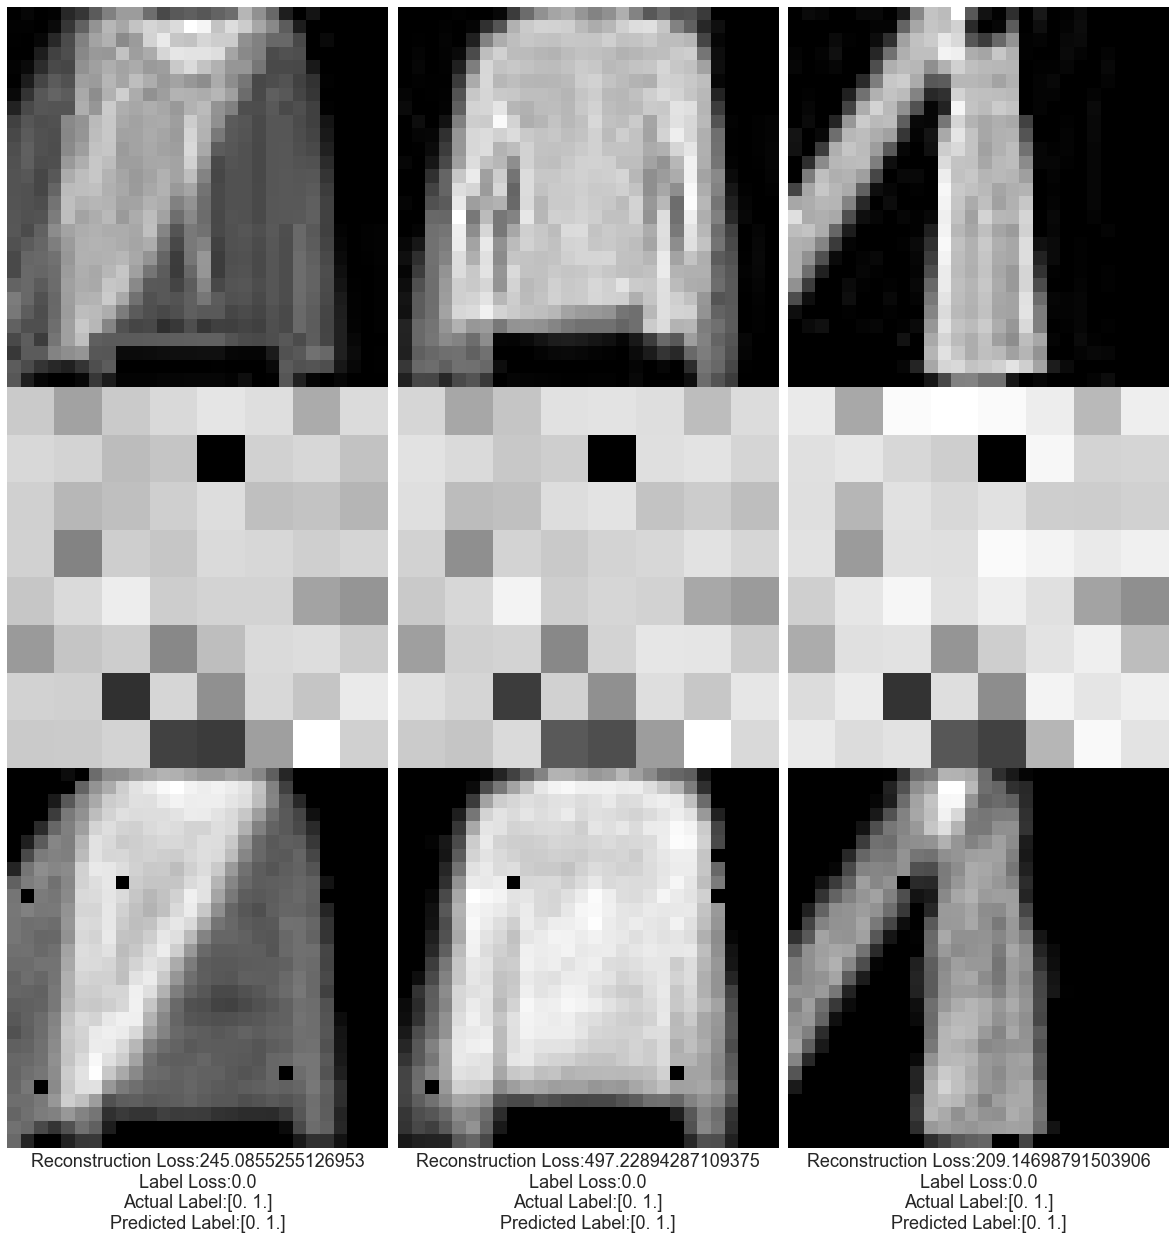

Accuracy of labels: 0.9898327589035034


In [19]:
"""
GET 3 RANDOM SETS OF ORIGINAL / LATENT / RECONSTRUCTION
Pulls from test set
"""
with torch.no_grad():
    
    #number of images to display at once
    #3 fits nicely on my jupyter notebook
    number = 3
    
    #initialize randomness in pulling images
    random.seed(a=None, version=2)
    i_offset = random.randint(0, len(test_examples)-number)
    
    #formatting
    plt.figure(figsize=(21, 21))
    plt.subplots_adjust(wspace=0.0,hspace=0.0)
    plt.tight_layout()
    
    for index in range(number):
        # display original
        ax = plt.subplot(3, number,index+1)
        plt.imshow(test_examples[index+i_offset].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display hidden layer?
        ax = plt.subplot(3, number,index + 1*number+1)
        plt.imshow(k_representations[index+i_offset])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, number, index +  2*number+1 )
        plt.imshow(reconstruction_examples[index+i_offset])
        plt.gray()
        
        #display loss under each picture
        recon_crit1 = torch.from_numpy(reconstruction_examples[index+i_offset])
        recon_crit2 = torch.from_numpy(test_examples[index+i_offset])
        
        label_crit1 = torch.from_numpy(test_labels[index+i_offset])
        label_crit2 = torch.from_numpy(np.array(actual_labels[index+i_offset]))
                
        ax.set_xlabel("Reconstruction Loss:"+str(criterion(recon_crit1,recon_crit2).item())
                      +"\nLabel Loss:"+str(criterion_classifier(label_crit1,label_crit2).item())
                      +"\nActual Label:"+str(np.array(actual_labels[index+i_offset]))
                      +"\nPredicted Label:"+str(test_labels[index+i_offset]),fontsize=18)
        
        #Hide x-axis ticks
        ax.axes.xaxis.set_ticks([])
        
        #ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        #print("Reconstruction Loss:"+str(criterion(torch.from_numpy(reconstruction_examples[index]),torch.from_numpy(test_examples[index].numpy().reshape(28,28))).item())+"\n"+"f")

    plt.show() # UNCOMMENT TO VIEW AUTOENCODER EXAMPLE
    
    #iterrate through all labels to calculate average loss
    total_label_loss = 0
    for i in range(len(test_labels)):
        total_label_loss += criterion_classifier(torch.from_numpy(test_labels[i]),torch.from_numpy(np.array(actual_labels[i])))
    accuracy = total_label_loss / len(test_labels)
    accuracy = 1-accuracy
    print("Accuracy of labels: "+str(float(accuracy)))
    

## Kmeans generator

In [101]:

n_classes = 2


nsamples, nx, ny = np.array(k_representations, dtype=np.double).shape
d2_k_representations = np.array(k_representations, dtype=np.double).reshape((nsamples,nx*ny))

data = scale(d2_k_representations)


"""
bench_k_means(KMeans(init='k-means++', n_clusters=n_classes, n_init=2),
          name="k-means++", data=data)

pca = PCA(n_components=n_classes).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_classes, n_init=1),
          name="PCA-based",
          data=data)
"""
# #############################################################################
# Visualize the results on PCA-reduced data

#reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_classes, n_init=2)
kmeans.fit(data)

"""
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect='auto', origin='lower')

#give different dots depending on class
mark = []
col = []
for i in range(len(test_labels)):
    #if labeled as rigid, give a col of V
    if int(test_labels[i][0])==1:
        mark.append('v')
        col.append('r')
    else:
        mark.append('^')
        col.append('b')

pbar = tqdm(range(len(test_labels)))
for i in pbar:
    plt.scatter(reduced_data[i][0],reduced_data[i][1],c=col[i],marker=mark[i],s=10)

#plt.plot(reduced_data[:, 0], reduced_data[:, 1], c=col[:], markersize=1)
# Plot the centroids as a white X
"""
centroids = kmeans.cluster_centers_
"""
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the MNIST-fashion dataset (PCA-reduced data)\n'
        'Centroids are marked with white cross\n'
         'Red down arrows are Rigid Images\n'
         'Blue up arrows are Nonrigid Images')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()
"""
print(np.shape(centroids))

(2, 64)


## Preprocess data for k-means accuracy

Creates acc_data[x][y]

x is an image/label pair

y can be 0 (to return latent image) or 1 (to return the one-hot label)

In [102]:
acc_data = []
for i in range(len(test_labels)):
    acc_data.append([k_representations[i].reshape(64),test_labels[i]])
    

#show size of your acc_data    
print(len(acc_data))


#arbitrary index to test an image/label pair
testIndex = 60

print(np.shape(acc_data[testIndex]))
print(acc_data[testIndex])


#show the latent image
plt.imshow(acc_data[testIndex][0].reshape(8, 8))
plt.gray()

plt.show()

1


IndexError: list index out of range

In [14]:
print("Shape of centroids: "+str(np.shape(centroids)))
print("Shape of data: "+str(np.shape(acc_data)))
print("Shape of latent image: "+str(np.shape(acc_data[0][0])))
print("Shape of latent label: "+str(np.shape(acc_data[0][1])))

acc = accuracy(centroids,acc_data)

print("Accuracy of Kmeans: "+ str(acc))

Shape of centroids: (2, 64)
Shape of data: (6000, 2)
Shape of latent image: (64,)
Shape of latent label: (2,)
Accuracy of Kmeans: 0.5001666666666666
